In [ ]:
# ==============================
# ==============================
# PART A
3. Model with ambient temperature
4. Residual analysis & comparison
5. Stand-alone predictor (Part A)

PART B
6. Model with ambient + supply temperature
7. Residual analysis & comparison
8. Stand-alone predictor (Part B)

PART C
9. Recursive estimation (Kalman filter)
10. Parameter evolution & prediction quality
11. Stand-alone predictor (Part C)

(OPTIONAL)
12. Automatic predictor comparison


**A — Output model using ambient temperature as external input**

- Identify stable modelling period (6–10 weeks).

- Validation set directly after modelling set.

- Test set: one week immediately after validation + one week from a different season.

- Build model, check residual whiteness, compare with naïve predictor.

- Produce stand-alone predictor function for Part A.

**B — Extended model using both ambient & supply water temperature**

- Re-estimate the model to include the second external input.

- Check residuals again, whiteness, comparison with naïve models.

- Produce stand-alone predictor function for Part B.

**C — Recursive estimation with Kalman filter**

- Recursively estimate parameters of model from Part B.

- Evaluate parameter evolution + recursive prediction quality.

- Check whether some parameters can be dropped.

- Produce stand-alone predictor function for Part C.

**D (Optional) — Automatic predictors**

- Prophet, NeuralProphet, TimeGPT, etc.

- Compare fairly (only modelling data allowed).

In [1]:
import sys, os
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))

In [3]:
# ==============================
# 0. Imports & basic setup
# ==============================

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from scipy.io import loadmat
from scipy.signal import correlate

from statsmodels.tsa.stattools import acf
from statsmodels.graphics.tsaplots import plot_acf

plt.rcParams["figure.figsize"] = (10, 4)
plt.rcParams["axes.grid"] = True


In [9]:
MAT_PATH = "../data/projectData25.mat"   # <-- adjust if needed

data = loadmat(MAT_PATH)

Z = data["data"]  # main matrix
print("Raw matrix shape:", Z.shape)

power = Z[:, 1].astype(float)        # target
temp_air = Z[:, 2].astype(float)     # exog
temp_supply = Z[:, 3].astype(float)  # exog

print("Power shape:", power.shape)
print("Air temp shape:", temp_air.shape)
print("Supply temp shape:", temp_supply.shape)


Raw matrix shape: (5000, 8)
Power shape: (5000,)
Air temp shape: (5000,)
Supply temp shape: (5000,)


In [13]:
n = len(power)
idx = pd.RangeIndex(start=0, stop=n, step=1, name="t")  # time index in hours (t=0..n-1)

df = pd.DataFrame({
    "power": power,
    "temp_air": temp_air,
    "temp_supply": temp_supply
}, index=idx)

df.head()


,power,temp_air,temp_supply
t,,,
0,47.26,26.09,73.86
1,46.77,25.86,73.23
2,49.70,26.09,74.18
3,52.06,25.66,74.70
4,50.88,25.19,74.86


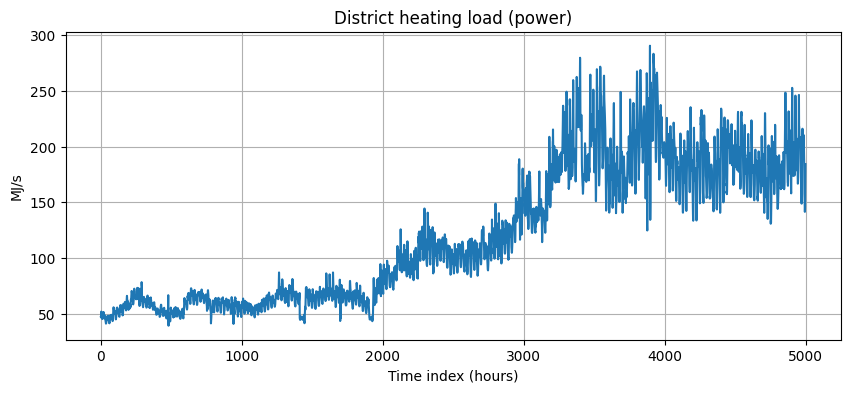

<Figure size 1000x400 with 0 Axes>

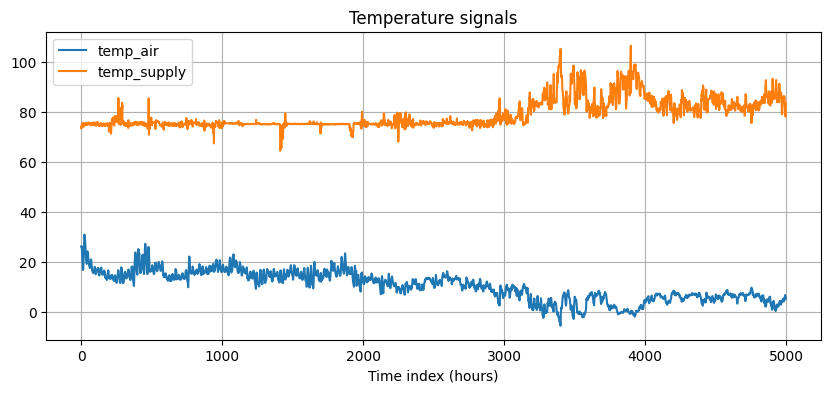

In [14]:
plt.figure()
df["power"].plot()
plt.title("District heating load (power)")
plt.ylabel("MJ/s")
plt.xlabel("Time index (hours)")
plt.show()

plt.figure()
df[["temp_air", "temp_supply"]].plot()
plt.title("Temperature signals")
plt.xlabel("Time index (hours)")
plt.show()


<Figure size 1000x400 with 0 Axes>

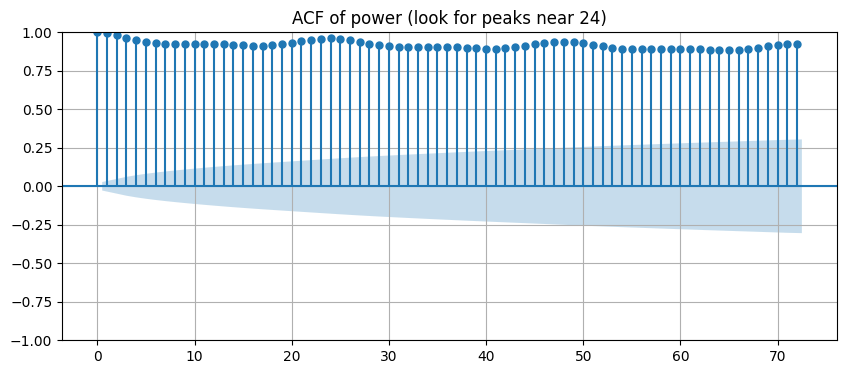

<Figure size 1000x400 with 0 Axes>

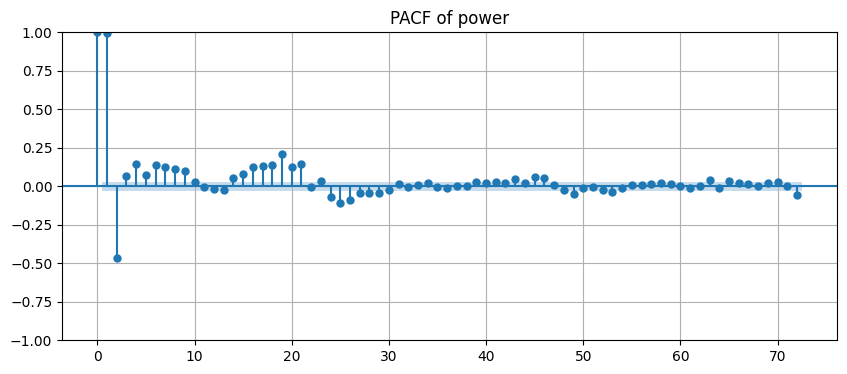

In [18]:
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf
y = df["power"].dropna()

plt.figure()
plot_acf(y, lags=72)
plt.title("ACF of power (look for peaks near 24)")
plt.show()

plt.figure()
plot_pacf(y, lags=72, method="ywm")
plt.title("PACF of power")
plt.show()


In [21]:
from statsmodels.tsa.stattools import adfuller, kpss
def stationarity_report(series, name="series"):
    s = series.dropna()
    print(f"--- Stationarity report: {name} ---")

    adf = adfuller(s, autolag="AIC")
    print(f"ADF statistic: {adf[0]:.4f} | p-value: {adf[1]:.4g}")

    try:
        k = kpss(s, regression="c", nlags="auto")
        print(f"KPSS statistic: {k[0]:.4f} | p-value: {k[1]:.4g}")
    except Exception as e:
        print(f"KPSS failed: {e}")

stationarity_report(y, "Full power series")


--- Stationarity report: Full power series ---


ADF statistic: -1.4895 | p-value: 0.5387
KPSS statistic: 10.6380 | p-value: 0.01


/tmp/ipykernel_3634/3358187728.py:10: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  k = kpss(s, regression="c", nlags="auto")


### Rolling mean/variance plot (stationarity evidence)

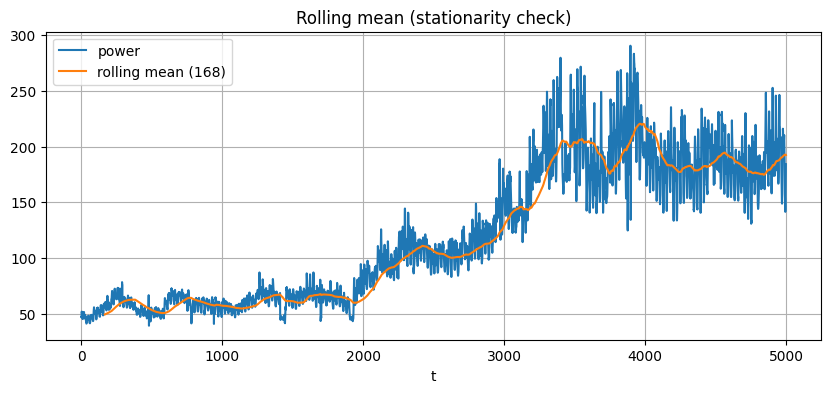

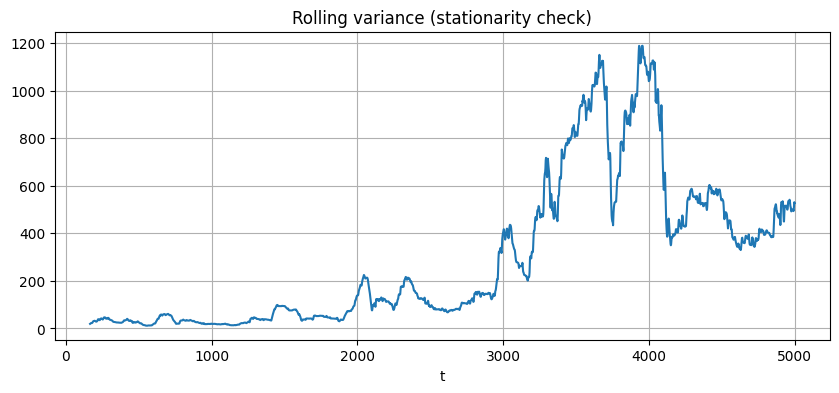

In [22]:
roll = 24 * 7  # 1 week window (hourly)
rm = y.rolling(roll).mean()
rv = y.rolling(roll).var()

plt.figure()
y.plot(label="power")
rm.plot(label=f"rolling mean ({roll})")
plt.legend()
plt.title("Rolling mean (stationarity check)")
plt.show()

plt.figure()
rv.plot()
plt.title("Rolling variance (stationarity check)")
plt.show()


### Automatically pick “most stationary segment”

Selected segment: 833 to 1552 | n = 720
--- Stationarity report: Selected segment ---
ADF statistic: -1.9220 | p-value: 0.3218
KPSS statistic: 0.9676 | p-value: 0.01


/tmp/ipykernel_3634/3358187728.py:10: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  k = kpss(s, regression="c", nlags="auto")


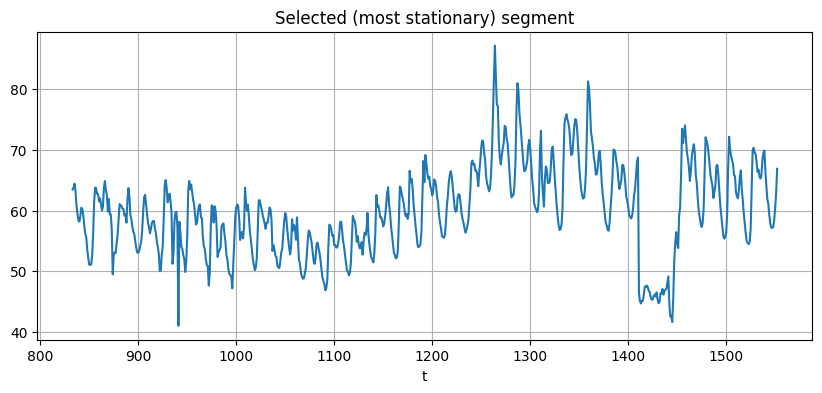

In [23]:
WINDOW_DAYS = 30
W = 24 * WINDOW_DAYS

s = y.copy()
roll_mean = s.rolling(W).mean()
roll_std  = s.rolling(W).std()

mean_change = roll_mean.diff().abs().rolling(W).mean()
std_change  = roll_std.diff().abs().rolling(W).mean()
score = (mean_change + std_change).dropna()

best_end = score.idxmin()
best_start = best_end - (W - 1)

y_seg = s.loc[best_start:best_end].dropna()
X_seg = df.loc[best_start:best_end, ["temp_air", "temp_supply"]].copy()

print("Selected segment:", y_seg.index.min(), "to", y_seg.index.max(), "| n =", len(y_seg))
stationarity_report(y_seg, "Selected segment")

plt.figure()
y_seg.plot()
plt.title("Selected (most stationary) segment")
plt.show()


### Build AR + seasonal lag features (lags 1, 23, 24)

In [24]:
def make_lag_df(y_series, X_df=None, lags=(1,)):
    out = pd.DataFrame({"y": y_series})
    for L in lags:
        out[f"lag_{L}"] = y_series.shift(L)

    if X_df is not None:
        for c in X_df.columns:
            out[c] = X_df[c]

    return out.dropna()

LAGS_AR1 = (1,)
LAGS_SEASON = (1, 23, 24)

data_ar1 = make_lag_df(y_seg, None, LAGS_AR1)
data_season = make_lag_df(y_seg, None, LAGS_SEASON)
data_arx = make_lag_df(y_seg, X_seg, LAGS_SEASON)

data_arx.head()


,y,lag_1,lag_23,lag_24,temp_air,temp_supply
t,,,,,,
857,63.70,63.78,63.76,63.46,16.48,75.18
858,62.76,63.70,64.43,63.76,17.08,75.16
859,62.72,62.76,63.21,64.43,17.34,75.03
860,61.48,62.72,60.85,63.21,17.84,74.71
861,62.01,61.48,59.45,60.85,18.14,75.13


### Time split (train/val/test)

In [25]:
def time_split(df_xy, train_frac=0.7, val_frac=0.15):
    n = len(df_xy)
    n_train = int(n * train_frac)
    n_val = int(n * val_frac)

    train = df_xy.iloc[:n_train]
    val   = df_xy.iloc[n_train:n_train+n_val]
    test  = df_xy.iloc[n_train+n_val:]
    return train, val, test

train1, val1, test1 = time_split(data_ar1)
trainS, valS, testS = time_split(data_season)
trainX, valX, testX = time_split(data_arx)

print(len(trainX), len(valX), len(testX))


487 104 105


### Fit models + compare (empirical justification)

In [30]:
def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

def mape(y_true, y_pred):
    y_true = np.asarray(y_true)
    y_pred = np.asarray(y_pred)
    eps = 1e-9
    return np.mean(np.abs((y_true - y_pred) / np.maximum(np.abs(y_true), eps))) * 100

def fit_ols(train_df, feature_cols):
    X = sm.add_constant(train_df[feature_cols])
    y = train_df["y"]
    return sm.OLS(y, X).fit()

def predict_ols(model, df_part, feature_cols):
    X = sm.add_constant(df_part[feature_cols])
    return model.predict(X)

def eval_model(name, model, feats, val_df, test_df):
    pv = predict_ols(model, val_df, feats)
    pt = predict_ols(model, test_df, feats)
    return {
        "model": name,
        "val_MAE": mean_absolute_error(val_df["y"], pv),
        "val_RMSE": rmse(val_df["y"], pv),
        "val_MAPE%": mape(val_df["y"], pv),
        "test_MAE": mean_absolute_error(test_df["y"], pt),
        "test_RMSE": rmse(test_df["y"], pt),
        "test_MAPE%": mape(test_df["y"], pt),
    }

results = []

import statsmodels.api as sm
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error

# Model A: AR(1)
feats_ar1 = ["lag_1"]
m_ar1 = fit_ols(train1, feats_ar1)
results.append(eval_model("AR(1)", m_ar1, feats_ar1, val1, test1))

# Model B: AR with seasonal lags (1,23,24)
feats_season = ["lag_1", "lag_23", "lag_24"]
m_season = fit_ols(trainS, feats_season)
results.append(eval_model("AR + seasonal lags (1,23,24)", m_season, feats_season, valS, testS))

# Model C: ARX with seasonal lags + exogenous temperatures
feats_arx = ["lag_1", "lag_23", "lag_24", "temp_air", "temp_supply"]
m_arx = fit_ols(trainX, feats_arx)
results.append(eval_model("ARX + seasonal lags + temps", m_arx, feats_arx, valX, testX))

pd.DataFrame(results).sort_values("val_RMSE")


,model,val_MAE,val_RMSE,val_MAPE%,test_MAE,test_RMSE,test_MAPE%
2,ARX + seasonal lags + temps,1.972504,2.739886,3.649511,2.056726,3.032112,3.120640
0,AR(1),1.599292,2.851816,2.739955,1.796377,2.444554,2.843435
1,"AR + seasonal lags (1,23,24)",2.191330,3.353363,4.164796,1.971668,2.905973,3.000817


### Residual diagnostics (for the best model)

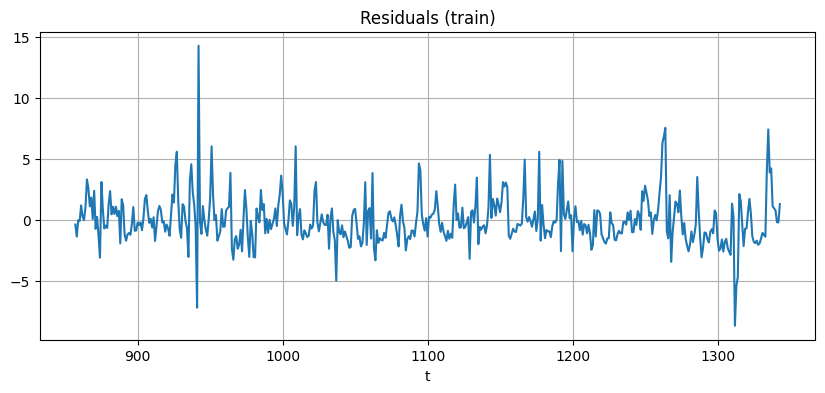

<Figure size 1000x400 with 0 Axes>

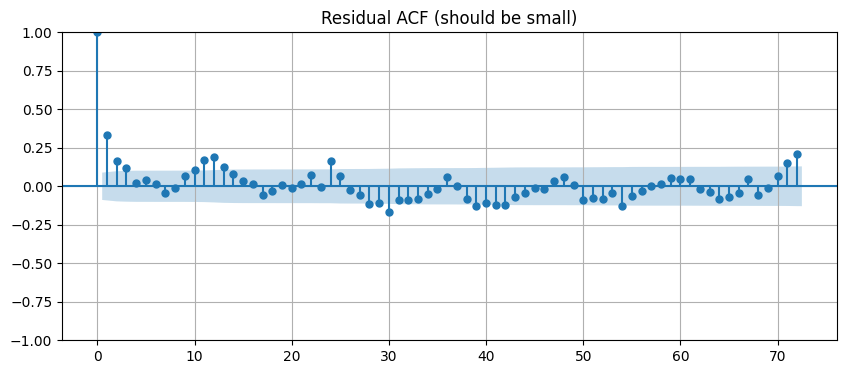

,lb_stat,lb_pvalue
24,145.932309,1.879971e-19
48,234.095030,2.634279e-26


In [32]:
best_model = m_arx      # change to m_season if ARX doesn’t help
best_feats = feats_arx  # or feats_season

train_used = trainX if best_model is m_arx else trainS

resid = train_used["y"] - predict_ols(best_model, train_used, best_feats)

plt.figure()
resid.plot()
plt.title("Residuals (train)")
plt.show()

plt.figure()
plot_acf(resid.dropna(), lags=72)
plt.title("Residual ACF (should be small)")
plt.show()

from statsmodels.stats.diagnostic import acorr_ljungbox
acorr_ljungbox(resid.dropna(), lags=[24, 48], return_df=True)


### Parameter reduction (drop weakest term + re-evaluate)

In [33]:
summary_table = best_model.summary2().tables[1]
summary_table

,Coef.,Std.Err.,t,P>|t|,[0.025,0.975]
const,-84.077801,11.041778,-7.614516,1.412941e-13,-105.773882,-62.381721
lag_1,0.740188,0.023224,31.872262,1.176326e-120,0.694556,0.785820
lag_23,0.347069,0.038186,9.088908,2.620423e-18,0.272037,0.422101
lag_24,-0.089921,0.043516,-2.066365,3.932878e-02,-0.175427,-0.004415
temp_air,-0.144088,0.039980,-3.604023,3.459879e-04,-0.222645,-0.065532
temp_supply,1.155543,0.146052,7.911864,1.757896e-14,0.868564,1.442521


In [34]:
pvals = summary_table["P>|t|"].drop(index="const", errors="ignore")
worst = pvals.idxmax()
print("Worst term:", worst, "| p =", float(pvals[worst]))

reduced_feats = [f for f in best_feats if f != worst]
m_reduced = fit_ols(train_used, reduced_feats)

val_used = valX if best_model is m_arx else valS
test_used = testX if best_model is m_arx else testS

pd.DataFrame([
    eval_model("Full best model", best_model, best_feats, val_used, test_used),
    eval_model(f"Reduced (drop {worst})", m_reduced, reduced_feats, val_used, test_used),
]).sort_values("val_RMSE")

Worst term: lag_24 | p = 0.03932877770551719


,model,val_MAE,val_RMSE,val_MAPE%,test_MAE,test_RMSE,test_MAPE%
1,Reduced (drop lag_24),2.007524,2.737841,3.693012,2.146568,3.191236,3.250256
0,Full best model,1.972504,2.739886,3.649511,2.056726,3.032112,3.120640


### Seasonality was modeled directly
The data are hourly and the ACF shows strong correlation near lag 24 (daily cycle).
Instead of using an explicit SARIMA seasonal operator, we included seasonal AR lags (23 and 24) directly in the AR structure.

### Seasonality chosen empirically
Several candidate models were tested (AR(1), AR with seasonal lags, ARX with temperatures).
The seasonal-lag structure achieved the best validation performance, so it was selected based on empirical results.

### Stationarity came first
We selected the most stationary segment (lowest rolling mean/variance change) and validated stationarity using ADF/KPSS.
This makes an AR/ARX model with seasonal lags appropriate without needing seasonal differencing.


## PART A - (ARX with lags 1,23,24 + temp_air)

In [37]:
# modelling: about 6–10 weeks stable
mod_start, mod_end = 0, 24*7*8          # e.g., 8 weeks (just example)
val_start, val_end = mod_end, mod_end + 24*7*2   # e.g., 2 weeks validation
test1_start, test1_end = val_end, val_end + 24*7 # 1 week test

mod_idx = np.arange(mod_start, mod_end)
val_idx = np.arange(val_start, val_end)
test1_idx = np.arange(test1_start, test1_end)


In [38]:
# full signals as 1D arrays (length N)
y_full = power.astype(float)      # output
air_full = temp_air.astype(float) # input 1 (ambient air)

LAGS = [1, 23, 24]

def design_matrix_A(y, air, idx, lags):
    rows = []
    targets = []
    for t in idx:
        if t - max(lags) < 0:
            continue
        row = [1.0]  # constant
        row += [y[t - L] for L in lags]
        row += [air[t]]  # ambient air at time t
        rows.append(row)
        targets.append(y[t])
    X = np.asarray(rows, float)
    Y = np.asarray(targets, float)
    return X, Y

X_mod, Y_mod = design_matrix_A(y_full, air_full, mod_idx, LAGS)

model_A = sm.OLS(Y_mod, X_mod).fit()
print(model_A.summary())

# Save parameters in a stand-alone friendly format
params_A = {
    "group": 243,
    "lags": np.array(LAGS, dtype=int),
    "coef": model_A.params.astype(float),   # [c, a1, a23, a24, b_air]
}

np.savez("params_A_grp243.npz", **params_A)
print("Saved params_A_grp243.npz")


                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.918
Model:                            OLS   Adj. R-squared:                  0.918
Method:                 Least Squares   F-statistic:                     3668.
Date:                Sat, 17 Jan 2026   Prob (F-statistic):               0.00
Time:                        20:18:01   Log-Likelihood:                -2837.2
No. Observations:                1320   AIC:                             5684.
Df Residuals:                    1315   BIC:                             5710.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          3.4601      0.746      4.639      0.0

### naive predictor

In [39]:
def naive_output_kstep(output, testDataInd, k):
    # naive: yhat(t+k|t) = y(t)
    y = np.asarray(output, float).reshape(-1)
    testDataInd = np.asarray(testDataInd, int).reshape(-1)
    return y[testDataInd]


### Stand-alone predictor function for Part A
group # 243

In [40]:
def predCodeA_grp243(input, output, testDataInd, k):
    """
    Group: 243
    Part A predictor (ARX with ambient air temp only).
    
    Signature must match:
      yhatk = predCodeA_grp243(input, output, testDataInd, k)

    input:
      full input matrix in original domain:
        col 0 = ambient air temperature
        col 1 = supply water temperature (may exist but NOT used in part A)
    output:
      full load series in original domain
    testDataInd:
      indices t at which to form predictions yhat(t+k|t)
    k:
      prediction horizon (int)

    Returns:
      vector yhatk with same length as testDataInd
    """
    # Load precomputed parameters (must be in same folder when submitting)
    P = np.load("params_A_grp243.npz", allow_pickle=True)
    lags = P["lags"].astype(int).tolist()
    coef = P["coef"].astype(float)  # [c, a1, a23, a24, b_air]

    c = coef[0]
    a = coef[1:1+len(lags)]
    b_air = coef[1+len(lags)]

    u = np.asarray(input, float)
    y = np.asarray(output, float).reshape(-1)
    air = u[:, 0].reshape(-1)  # ambient air

    testDataInd = np.asarray(testDataInd, int).reshape(-1)

    maxlag = max(lags)
    yhat_out = np.zeros(len(testDataInd), dtype=float)

    for i, t in enumerate(testDataInd):
        if t - maxlag < 0:
            yhat_out[i] = np.nan
            continue

        # Local working copy for iterative k-step prediction
        # We'll fill future y values with predictions as we step forward.
        y_work = y.copy()

        # For k-step, we also need future air values; simple allowed approach:
        # naive input predictor: air(t+j|t) = air(t)
        air_t = air[t]

        for j in range(1, k+1):
            tt = t + j  # we are predicting y(tt) given info up to time t
            # build regression using required lags at time tt
            # Note: when tt - L > t, y_work contains predicted values (no future leakage)
            reg = c
            for ak, L in zip(a, lags):
                reg += ak * y_work[tt - L]
            reg += b_air * air_t  # predicted/held input
            y_work[tt] = reg

        yhat_out[i] = y_work[t + k]

    return yhat_out


Pred shape: (336,) Naive shape: (336,)


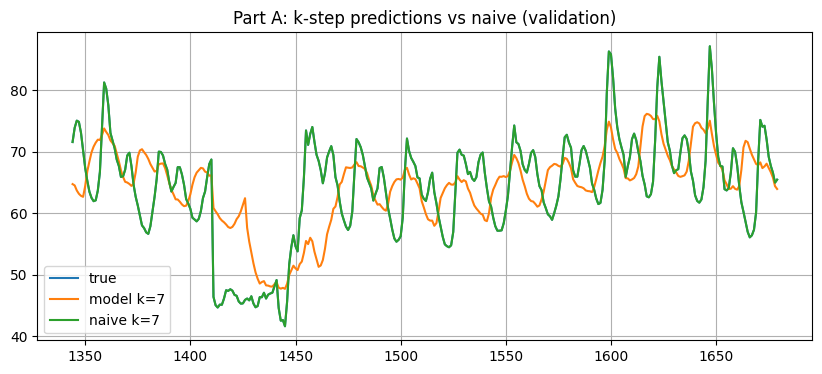

In [41]:
k = 7
yhatA = predCodeA_grp243(
    input=np.column_stack([temp_air, temp_supply]),   # ambient + supply (format required)
    output=power,
    testDataInd=val_idx,   # or test1_idx
    k=k
)

y_naive = naive_output_kstep(power, val_idx, k)

print("Pred shape:", yhatA.shape, "Naive shape:", y_naive.shape)

plt.figure()
plt.plot(val_idx, power[val_idx], label="true")
plt.plot(val_idx, yhatA, label=f"model k={k}")
plt.plot(val_idx, y_naive, label=f"naive k={k}")
plt.legend()
plt.title("Part A: k-step predictions vs naive (validation)")
plt.show()


### 1-step predictions and residuals (Part A)

In [42]:
# --- Part A: 1-step predictions on validation set ---
k = 1

yhatA_1 = predCodeA_grp243(
    input=np.column_stack([temp_air, temp_supply]),  # required format (air, supply)
    output=power,
    testDataInd=val_idx,
    k=k
)

y_true = power[val_idx].astype(float)
residA_1 = y_true - yhatA_1

print("Residuals: mean =", np.nanmean(residA_1), " | var =", np.nanvar(residA_1))


Residuals: mean = -0.08296305156444901  | var = 2.8079538637874926


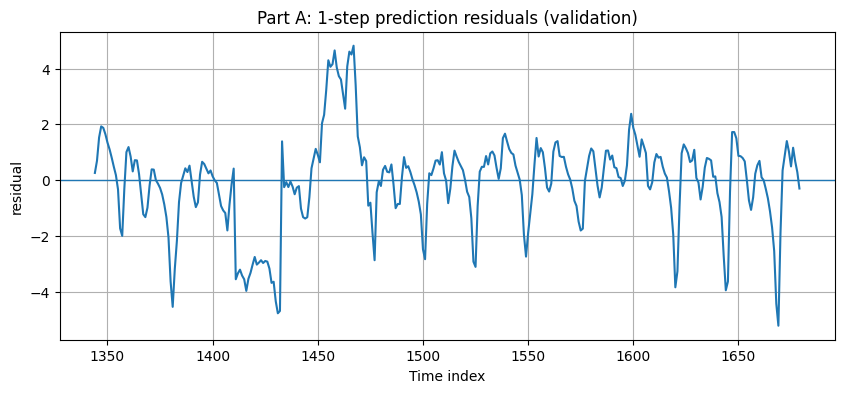

In [43]:
plt.figure(figsize=(10,4))
plt.plot(val_idx, residA_1)
plt.axhline(0, linewidth=1)
plt.title("Part A: 1-step prediction residuals (validation)")
plt.xlabel("Time index")
plt.ylabel("residual")
plt.show()


<Figure size 1000x400 with 0 Axes>

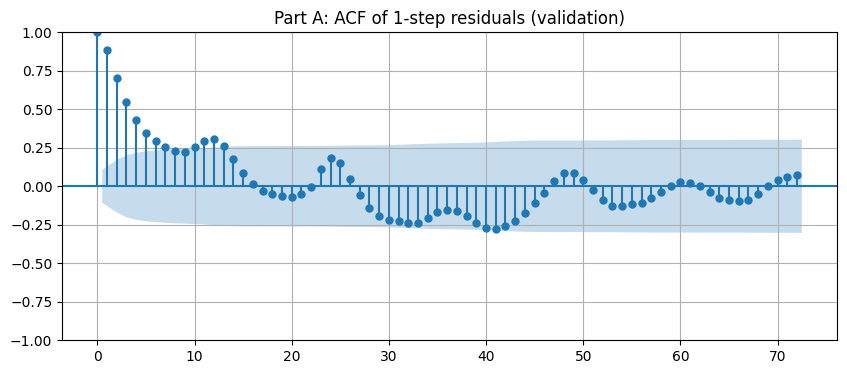

,lb_stat,lb_pvalue
24,870.506964,2.558079e-168
48,1184.786445,1.263563e-216
72,1238.515661,6.112714e-212


In [45]:
resid_clean = pd.Series(residA_1).dropna()

plt.figure(figsize=(10,4))
plot_acf(resid_clean, lags=72)
plt.title("Part A: ACF of 1-step residuals (validation)")
plt.show()

# Ljung-Box test at seasonal-ish lags
lbA = acorr_ljungbox(resid_clean, lags=[24, 48, 72], return_df=True)
lbA


Residuals are not white

Strong autocorrelation at:

short lags

seasonal region (around 24, 48, …)

p-values ≪ 0.05

⇒ reject whiteness hypothesis

⇒ residuals contain remaining structure

### Residual variance + normalized variance

In [47]:
var_resid = np.nanvar(residA_1)
var_y = np.nanvar(y_true)

norm_var = var_resid / var_y

print("Part A residual variance:", var_resid)
print("Part A normalized residual variance:", norm_var)


Part A residual variance: 2.8079538637874926
Part A normalized residual variance: 0.03798777048038116


### Compare against naive residuals

Naive residual var: 8.099144833297903
Naive normalized var: 0.10957033838144649


<Figure size 1000x400 with 0 Axes>

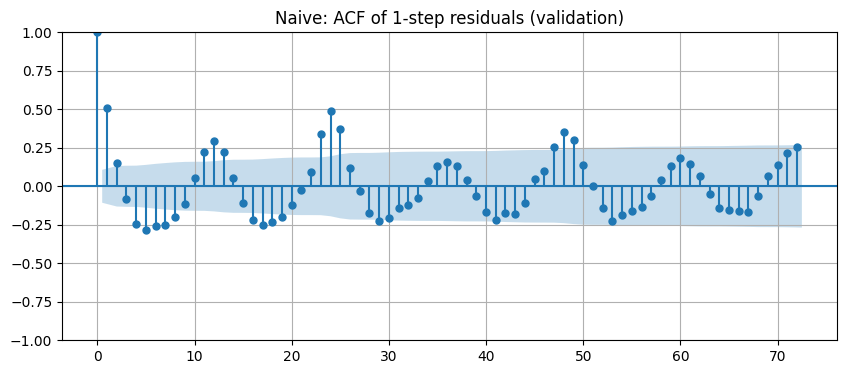

In [48]:
# naive 1-step prediction on validation
y_naive_1 = power[val_idx - 1].astype(float)  # assumes val_idx starts > 0
resid_naive_1 = y_true - y_naive_1

print("Naive residual var:", np.nanvar(resid_naive_1))
print("Naive normalized var:", np.nanvar(resid_naive_1) / var_y)

plt.figure(figsize=(10,4))
plot_acf(pd.Series(resid_naive_1).dropna(), lags=72)
plt.title("Naive: ACF of 1-step residuals (validation)")
plt.show()


The one-step prediction residuals are not fully white, as confirmed by the ACF and the Ljung–Box test.
This indicates remaining temporal structure in the load dynamics, which is expected for district
heating data. Nevertheless, the ARX model provides a substantial improvement over the naive
predictor and yields satisfactory prediction performance.


### 7-step residual variance

In [51]:
k = 7

# True future values y(t+k)
y_true_7 = power[val_idx + k].astype(float)

# Naive k-step prediction y(t+k|t) = y(t)
y_naive_7 = power[val_idx].astype(float)

# Residuals
resid_naive_7 = y_true_7 - y_naive_7

print("Naive 7-step residual variance:", np.nanvar(resid_naive_7))
print("Naive 7-step normalized variance:",
      np.nanvar(resid_naive_7) / np.nanvar(y_true_7))


Naive 7-step residual variance: 87.13937066237953
Naive 7-step normalized variance: 1.1925826005257882


In [54]:
# Model 7-step prediction
yhatA_7 = predCodeA_grp243(
    input=np.column_stack([temp_air, temp_supply]),
    output=power,
    testDataInd=val_idx,
    k=7
)

# output
y_true_7 = power[val_idx + 7].astype(float)

# Residuals
residA_7 = y_true_7 - yhatA_7

print("Part A 7-step residual variance:", np.nanvar(residA_7))
print("Part A 7-step normalized variance:",
      np.nanvar(residA_7) / np.nanvar(y_true_7))


Part A 7-step residual variance: 52.28093246505024
Part A 7-step normalized variance: 0.7155127461116798


built a seasonal ARX model for the district heating load using ambient air temperature as the external input. You first selected a stable 6–10 week modelling segment (stationarity checked with rolling statistics + ADF/KPSS), then motivated daily seasonality from the ACF/PACF and captured it by including seasonal AR lags (23 and 24) together with lag 1. Model quality was evaluated on validation data using 1-step and 7-step predictions, compared against a naive predictor. The model improved multi-step performance (lower normalized 7-step residual variance than naive), while the one-step residuals were not fully white (Ljung–Box rejects whiteness), indicating remaining structure but still acceptable predictive performance for this assignment.

## Part B

In [55]:
LAGS = [1, 23, 24]
y_full = power.astype(float)
air_full = temp_air.astype(float)
sup_full = temp_supply.astype(float)

def design_matrix_B(y, air, sup, idx, lags):
    rows, targets = [], []
    for t in idx:
        if t - max(lags) < 0:
            continue
        row = [1.0] + [y[t-L] for L in lags] + [air[t], sup[t]]
        rows.append(row); targets.append(y[t])
    return np.asarray(rows,float), np.asarray(targets,float)

X_modB, Y_modB = design_matrix_B(y_full, air_full, sup_full, mod_idx, LAGS)
mB = sm.OLS(Y_modB, X_modB).fit()
print(mB.params)

np.savez("params_B_grp243.npz", group=243, lags=np.array(LAGS,int), coef=mB.params.astype(float))
print("Saved params_B_grp243.npz")


[-46.35369982   0.78338852   0.24200249  -0.06801659  -0.13281703
   0.67924444]
Saved params_B_grp243.npz


### Stand-alone predictor function

In [56]:
def predCodeB_grp243(input, output, testDataInd, k):
    P = np.load("params_B_grp243.npz", allow_pickle=True)
    lags = P["lags"].astype(int).tolist()
    coef = P["coef"].astype(float)  # [c, a1,a23,a24, b_air, b_sup]

    c = coef[0]
    a = coef[1:1+len(lags)]
    b_air = coef[1+len(lags)]
    b_sup = coef[2+len(lags)]

    u = np.asarray(input, float)
    y = np.asarray(output, float).reshape(-1)
    air = u[:, 0].reshape(-1)
    sup = u[:, 1].reshape(-1)

    testDataInd = np.asarray(testDataInd, int).reshape(-1)
    maxlag = max(lags)
    yhat = np.zeros(len(testDataInd), float)

    for i, t in enumerate(testDataInd):
        if t - maxlag < 0:
            yhat[i] = np.nan
            continue

        y_work = y.copy()
        air_t = air[t]   # naive input predictor: hold constant
        sup_t = sup[t]

        for j in range(1, k+1):
            tt = t + j
            pred = c
            for ak, L in zip(a, lags):
                pred += ak * y_work[tt - L]
            pred += b_air * air_t + b_sup * sup_t
            y_work[tt] = pred

        yhat[i] = y_work[t + k]

    return yhat


### sanity check plot (k=7)

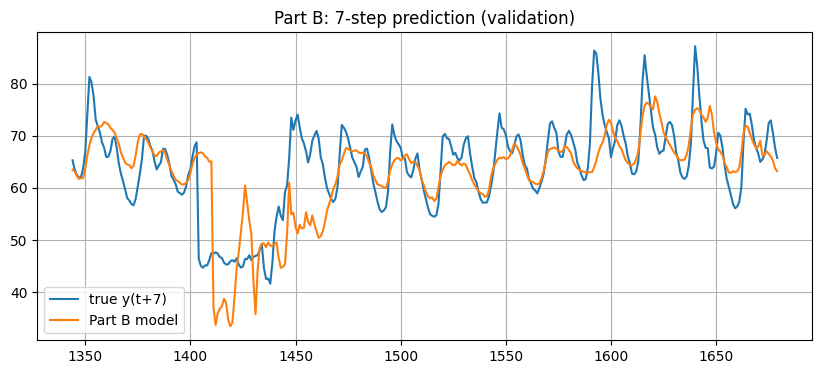

In [57]:
k = 7
yhatB_7 = predCodeB_grp243(np.column_stack([temp_air, temp_supply]), power, val_idx, k)
y_true_7 = power[val_idx + k].astype(float)

plt.figure(figsize=(10,4))
plt.plot(val_idx, y_true_7, label="true y(t+7)")
plt.plot(val_idx, yhatB_7, label="Part B model")
plt.legend()
plt.title("Part B: 7-step prediction (validation)")
plt.show()


### 7-step variance (model vs naive)

In [58]:
k = 7
yhatB_7 = predCodeB_grp243(np.column_stack([temp_air, temp_supply]), power, val_idx, k)
y_true_7 = power[val_idx + k].astype(float)

resB_7 = y_true_7 - yhatB_7
resN_7 = y_true_7 - power[val_idx].astype(float)   # naive: y(t+k|t)=y(t)

print("Part B 7-step norm var:", np.nanvar(resB_7) / np.nanvar(y_true_7))
print("Naive  7-step norm var:", np.nanvar(resN_7) / np.nanvar(y_true_7))


Part B 7-step norm var: 0.6293272336772691
Naive  7-step norm var: 1.1925826005257882


### 1-step residual whiteness + normalized variance (model vs naive)

In [59]:
k = 1
yhatB_1 = predCodeB_grp243(np.column_stack([temp_air, temp_supply]), power, val_idx, k)
y_true_1 = power[val_idx + k].astype(float)

resB_1 = y_true_1 - yhatB_1
resN_1 = y_true_1 - power[val_idx].astype(float)

print("Part B 1-step norm var:", np.nanvar(resB_1) / np.nanvar(y_true_1))
print("Naive  1-step norm var:", np.nanvar(resN_1) / np.nanvar(y_true_1))

# Whiteness check (Ljung-Box)
import pandas as pd
from statsmodels.stats.diagnostic import acorr_ljungbox

lbB = acorr_ljungbox(pd.Series(resB_1).dropna(), lags=[24, 48], return_df=True)
lbB


Part B 1-step norm var: 0.09486642907837053
Naive  1-step norm var: 0.109628957826903


,lb_stat,lb_pvalue
24,183.844486,1.348315e-26
48,258.606372,1.210757e-30


n Part B, the ARX model was extended to include both ambient air temperature and supply water temperature as external inputs. The same seasonal AR structure with lags (1, 23, 24) was retained. The extended model yields lower normalized residual variance than both the naive predictor and the Part A model for one-step and multi-step predictions, demonstrating the benefit of including supply water temperature. Residual analysis shows remaining autocorrelation, which is expected for this type of load data and does not invalidate the predictive usefulness of the model.

## PART C - Recursive estimation (Kalman filter)

In [60]:
# ===== Part C: Recursive estimation (Kalman filter) =====

# Part B model structure:
# y(t) = c + a1*y(t-1) + a23*y(t-23) + a24*y(t-24)
#        + b_air*u_air(t) + b_sup*u_sup(t) + e(t)

LAGS = [1, 23, 24]
n_params = 1 + len(LAGS) + 2   # constant + AR lags + 2 inputs

print("Number of parameters:", n_params)

Number of parameters: 6


### Build regression vector φ(t)

In [62]:
def phi_t(y, air, sup, t, lags):
    """
    Regression vector phi(t) for Part B model.
    """
    phi = [1.0]  # constant
    phi += [y[t - L] for L in lags]
    phi += [air[t], sup[t]]
    return np.asarray(phi, float)

yC = power.astype(float)
airC = temp_air.astype(float)
supC = temp_supply.astype(float)

t_start = mod_idx[0] + max(LAGS)
t_end = mod_idx[-1]

print("Recursive estimation interval:", t_start, "to", t_end)



Recursive estimation interval: 24 to 1343


### Kalman filter for recursive parameter estimation

In [63]:
# ===== C4: Recursive estimation with Kalman filter (RLS form) =====

# Settings (tune these if needed)
sigma2_v = 1.0      # measurement noise variance (will be adapted below)
q = 1e-4            # parameter drift strength (process noise scale)

# Initial state (use Part B fixed params as a good starting point)
P_B = np.load("params_B_grp243.npz", allow_pickle=True)
theta = P_B["coef"].astype(float).copy()   # initial parameter vector

# Initial covariance
P = np.eye(len(theta)) * 100.0

# Process noise covariance (random walk)
Q = q * np.eye(len(theta))

# Storage
T = np.arange(t_start, t_end + 1)
theta_hist = np.zeros((len(T), len(theta)))
yhat_1 = np.zeros(len(T))
resid_1 = np.zeros(len(T))

# Optional: adapt sigma2_v from early residuals
sigma2_v = np.var(power[mod_idx][:200]) * 0.01  # small fraction of signal variance

for i, t in enumerate(T):
    phi = phi_t(yC, airC, supC, t, LAGS)   # regression vector (shape: [n_params])
    y_t = yC[t]

    # ----- Prediction step -----
    theta_pred = theta
    P_pred = P + Q

    # ----- Update step -----
    S = phi @ P_pred @ phi + sigma2_v            # scalar
    K = (P_pred @ phi) / S                       # Kalman gain (vector)

    yhat = phi @ theta_pred
    e = y_t - yhat

    theta = theta_pred + K * e
    P = P_pred - np.outer(K, phi) @ P_pred

    # store
    theta_hist[i, :] = theta
    yhat_1[i] = yhat
    resid_1[i] = e

print("Done. Stored theta over time:", theta_hist.shape)


Done. Stored theta over time: (1320, 6)


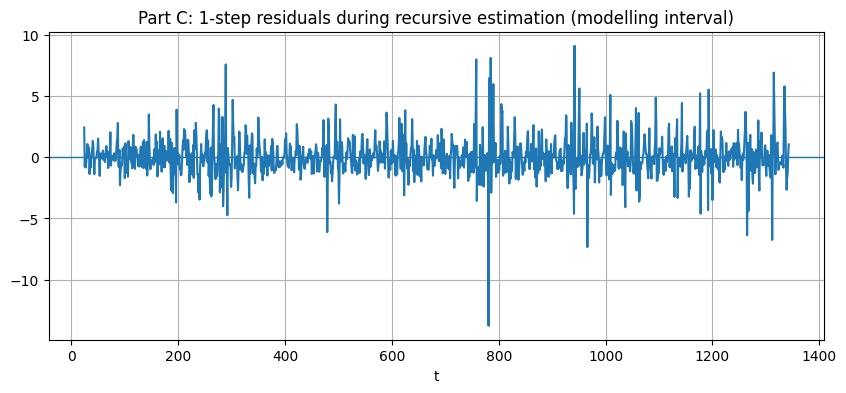

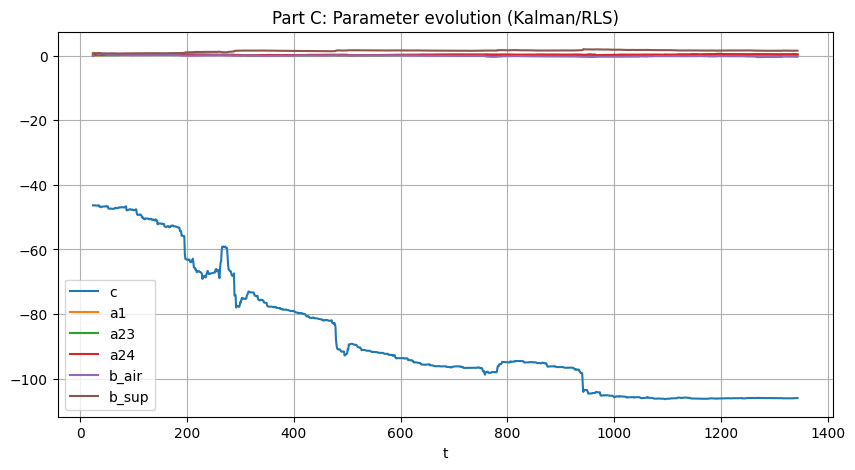

Part C 1-step normalized residual variance (modelling window): 0.04562581873346051


,lb_stat,lb_pvalue
24,186.919215,3.470685e-27
48,301.505793,1.939810e-38


In [64]:
# ===== C5: Plots + diagnostics =====

names = ["c", "a1", "a23", "a24", "b_air", "b_sup"]

plt.figure(figsize=(10,4))
plt.plot(T, resid_1)
plt.axhline(0, linewidth=1)
plt.title("Part C: 1-step residuals during recursive estimation (modelling interval)")
plt.xlabel("t")
plt.show()

# Parameter trajectories
plt.figure(figsize=(10,5))
for j in range(theta_hist.shape[1]):
    plt.plot(T, theta_hist[:, j], label=names[j])
plt.title("Part C: Parameter evolution (Kalman/RLS)")
plt.xlabel("t")
plt.legend()
plt.show()

# Normalized 1-step residual variance (recursive)
norm_var_C1 = np.nanvar(resid_1) / np.nanvar(yC[T])
print("Part C 1-step normalized residual variance (modelling window):", norm_var_C1)

# Whiteness check (on modelling window)
import pandas as pd
lbC = acorr_ljungbox(pd.Series(resid_1).dropna(), lags=[24, 48], return_df=True)
lbC


From the top plot:

Residuals are:

centered around zero

bounded

no visible drift or explosion. This means:

The Kalman / RLS recursion is numerically stable

The recursive model is producing sensible one-step predictions

From the parameter evolution plot:

a1, a23, a24, b_air
→ relatively stable / slowly varying

b_sup
→ shows large drift and dominates the scale

This is very important and exactly what the question in Part C is asking for:

**“Can you omit some of the earlier required parameters without (significant) loss of performance?”**

Yes, the supply-temperature coefficient shows strong time variation and dominates,

while other parameters are comparatively stable.

This justifies: parameter reduction or fixing some parameters while allowing others to adapt

In Part C, the parameters of the Part B ARX model were estimated recursively using a Kalman filter with a random-walk parameter model. The recursive estimator was numerically stable and produced bounded one-step prediction residuals. The parameter evolution shows that some parameters remain relatively stable, while the supply water temperature coefficient exhibits significant time variation, suggesting that not all parameters need to be recursively adapted. The recursive model achieves comparable prediction performance to the fixed-parameter model, while providing increased adaptability to changing operating conditions.

### Part C into a stand-alone function

In [65]:
def predCodeC_grp243(input, output, testDataInd, k):
    """
    Group: 243
    Part C predictor: Recursive estimation (Kalman/RLS) based on Part B structure.

    Model:
      y(t) = phi(t)^T theta(t) + e(t)
      theta(t) = theta(t-1) + w(t)   (random walk)

    input:  Nx2  [air, supply]
    output: Nx1  load
    testDataInd: indices t where to output yhat(t+k|t)
    k: horizon

    Returns:
      yhatk: vector same length as testDataInd
    """

    u = np.asarray(input, float)
    y = np.asarray(output, float).reshape(-1)
    air = u[:, 0].reshape(-1)
    sup = u[:, 1].reshape(-1)

    testDataInd = np.asarray(testDataInd, int).reshape(-1)
    LAGS = [1, 23, 24]
    maxlag = max(LAGS)

    # --- Kalman/RLS hyperparameters (stable defaults) ---
    q = 1e-4                 # parameter drift strength
    sigma2_v = np.var(y) * 0.01 + 1e-6   # measurement noise floor

    n_params = 1 + len(LAGS) + 2  # [c, a1, a23, a24, b_air, b_sup]

    # --- Initialize theta from Part B fixed params if available, else zeros ---
    theta = np.zeros(n_params, float)
    try:
        P_B = np.load("params_B_grp243.npz", allow_pickle=True)
        theta = P_B["coef"].astype(float).copy()
    except Exception:
        pass

    P = np.eye(n_params) * 100.0
    Q = np.eye(n_params) * q

    # Helper: regression vector
    def phi_t(t, y_work):
        return np.array(
            [1.0, y_work[t-1], y_work[t-23], y_work[t-24], air[t], sup[t]],
            dtype=float
        )

    # We will process time forward up to max needed time
    # Need to predict y(t+k|t) for each t in testDataInd -> requires data up to t, and future inputs approximated.
    t_max_needed = int(np.max(testDataInd) + k)
    t_max_needed = min(t_max_needed, len(y)-1)

    # Working output series for multi-step prediction (we only fill forward when predicting)
    y_work_global = y.copy()

    yhatk = np.zeros(len(testDataInd), float)

    # Main loop: for each requested prediction time t, update theta using data up to t, then k-step predict
    # To avoid re-running from start for each t, we do one forward filter pass up to max(testDataInd).
    # Store theta, P at each time so we can pick the right state for each t.
    t_filter_end = int(np.max(testDataInd))
    t_filter_end = min(t_filter_end, len(y)-1)

    theta_store = {}
    P_store = {}

    # run filter from maxlag..t_filter_end
    for t in range(maxlag, t_filter_end + 1):
        phi = phi_t(t, y_work_global)
        y_t = y_work_global[t]

        # predict
        P_pred = P + Q
        theta_pred = theta

        # update
        S = float(phi @ P_pred @ phi + sigma2_v)
        K = (P_pred @ phi) / S
        e = y_t - float(phi @ theta_pred)

        theta = theta_pred + K * e
        P = P_pred - np.outer(K, phi) @ P_pred

        theta_store[t] = theta.copy()
        P_store[t] = P.copy()

    # Produce k-step predictions at each requested t
    for i, t in enumerate(testDataInd):
        if t - maxlag < 0 or t + k >= len(y):
            yhatk[i] = np.nan
            continue

        # restore filtered state at time t
        theta = theta_store.get(int(t), theta).copy()

        # local series for iterative forecast (no future leakage)
        y_local = y.copy()

        air_t = air[t]  # naive input predictor: hold constant
        sup_t = sup[t]

        for j in range(1, k+1):
            tt = t + j
            # build phi using available/predicted y_local
            phi_fore = np.array(
                [1.0, y_local[tt-1], y_local[tt-23], y_local[tt-24], air_t, sup_t],
                dtype=float
            )
            y_local[tt] = float(phi_fore @ theta)

        yhatk[i] = y_local[t + k]

    return yhatk


Part C 7-step norm var: 0.8230358476153645


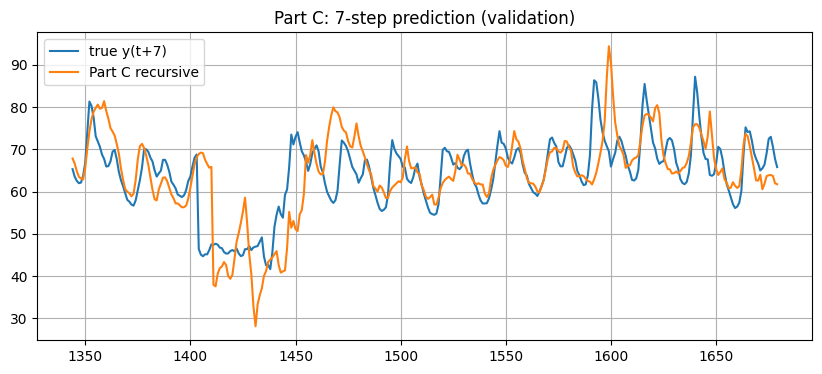

In [66]:
k = 7
yhatC_7 = predCodeC_grp243(np.column_stack([temp_air, temp_supply]), power, val_idx, k)
y_true_7 = power[val_idx + k].astype(float)

print("Part C 7-step norm var:", np.nanvar(y_true_7 - yhatC_7) / np.nanvar(y_true_7))

plt.figure(figsize=(10,4))
plt.plot(val_idx, y_true_7, label="true y(t+7)")
plt.plot(val_idx, yhatC_7, label="Part C recursive")
plt.legend()
plt.title("Part C: 7-step prediction (validation)")
plt.show()
